## SVP100 - Runners Analysis

In August of 2017 I ran my first 100KM off-road trail running race, finishing in 12 hours and 1 minute. I want to use this notebook to see how my performance changed as the race progressed. How does my pace compare to other runners throughout the race?

This notebook will use the following packages:

* BeautifulSoup: Scraping the data from race result webpage
* Pandas: Organising and analysing the data
* Matplotlib and seaborn: Displaying the data
* Other supporting packages


### Import packages and set plot configurations

In [60]:
# Import the packages we'll use for our analysis

import pandas as pd
import datetime
import requests
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [ ]:
# Use line magic function to enable matplotlib to work interactively with iPython

%matplotlib inline
%pylab inline

# Set style to fivethirtyeight to create clean and clear looking graphs

style.use('fivethirtyeight')

# Define a dictionary containing default plotting configurations

params = {'legend.fontsize': 'small',
          'figure.figsize': (9, 3),
         'axes.labelsize': 'small',
         'axes.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}

pylab.rcParams.update(params)

### Create class for scraping and organising data

In [62]:
# Define a class Results for creating Pandas dataframe objects of scrapped data from race results website 

class Results():
    """
    PLACEHOLDER: Add some details
    """
    
    def __init__(self, year=2017):
        self.year = year
        
    def scrape_to_df(self):
        url = r'http://www.svp100.co.uk/results-{}'.format(self.year)
        r = requests.get(url).text
        soup = BeautifulSoup(r, 'lxml')
        
        columns = ["pos", "name", "bib", "gender", "start", "club", 
           "cp1", "cp2", "cp3", "cp4", "cp5", "cp6", "finish", "total"] 
        
        list_columns = []
        for i in columns: 
            globals()[i] = []
            list_columns.append(globals()[i])
        
        rows = soup.find_all('tr')[1:]
        
        for row in rows:
            col = row.find_all('td')
            for (counter, value), column in zip(enumerate(col), list_columns):
                if not col[counter].string == None:
                    column.append(col[counter].string.strip())
                else: column.append("")
        
        df = pd.DataFrame({'pos':pos,'name': name,'bib': bib,
                  'gender': gender,'start': start,'club': club,'CP1': cp1,'CP2': cp2,'CP3': cp3,'CP4': cp4,
                  'CP5': cp5,'CP6': cp6,'finish': finish,'total': total}, index = name)
                
        return df
    
    def format_df(self):
        df = self.scrape_to_df()
        df["total"] = [i.encode("utf-8") for i in df["total"]]
        
        def str_to_min(x):
            if not x == '':
                hr_s = float((''.join(x[0]+x[1])))*(60*60)
                min_s = float(''.join(x[3]+x[4]))*60
                sec_s = float(''.join(x[6]+x[7]))
                total_min = ((hr_s + min_s + sec_s)/ 60)
                return round(total_min, 2)
        
        df['total_min'] = df['total'].map(str_to_min)
        df["average_min"] = round(df["total_min"].mean(), 2)
        df["start"] = datetime.datetime(2017, 8, 12, 7, 0 ,0)
        
        def cp2dt(cp):
            df[cp] = pd.to_datetime(df[cp], format = "%H:%M:%S", errors="coerce")
            df[cp] = df[cp].apply(lambda dt: dt.replace(year = 2017, month = 8, day=12))
            return df[cp]
        
        cps = ["CP1","CP2","CP3","CP4","CP5","CP6","finish"]
        for i in cps: df[i] = cp2dt(i)
        
        df["time2cp1"] = df["CP1"] - df["start"]
        df["time2cp2"] = df["CP2"] - df["CP1"] 
        df["time2cp3"] = df["CP3"] - df["CP2"] 
        df["time2cp4"] = df["CP4"] - df["CP3"] 
        df["time2cp5"] = df["CP5"] - df["CP4"]
        df["time2cp6"] = df["CP6"] - df["CP5"]
        df["time2end"] = df["finish"] - df["CP6"]
        
        return df
    
    def top_runners(self, x = 10):
        
        df = self.format_df()[:x]
        return df
    
    def target_runners(self, x = "Stephen Lemasney"):
        
        df = self.format_df().loc["Stephen Lemasney"]
        df = pd.DataFrame(df)
        
        return df

In [36]:
# Next define a standalone function for creating averages from the Results() objects

def average_pace(df):

    df = pd.DataFrame(df)

    convert_km = 1.60934
    cp = ["time2cp1", "time2cp2", "time2cp3", "time2cp4", "time2cp5", "time2cp6", "time2end"]
    cp_miles = [12, 23, 33, 44, 50, 58.5, 63]
    cp_miles_s = [12,11,10,11,6,8.5,4.5]
    cp_distances = pd.DataFrame({"cp_miles": cp_miles, "cp_miles_s": cp_miles_s}, index = cp)
    cp_distances["cp_km"] = cp_distances["cp_miles"] * convert_km
    cp_distances["cp_km_s"] = cp_distances["cp_miles_s"] * convert_km

    df_time2cp = pd.DataFrame(df, columns= cp)
    df_averages = {}
    for i in cp: df_averages[str(i)] = df_time2cp[str(i)].mean()

    df_averages = pd.Series(df_averages, name = "2017")
    df_averages = pd.DataFrame(df_averages)
    df_averages = (df_averages.join(cp_distances))
    df_averages["2017_min"] = [(i.total_seconds()/60) for i in df_averages["2017"]]
    df_averages["min_km"] = df_averages["2017_min"]/df_averages["cp_km_s"]

    return df_averages


### Initialize a Results() object with results from 2017 race

In [37]:
results = Results(year = 2017)
all_runners = results.format_df()
all_runners = average_pace(all_runners)
all_runners

,2017,cp_miles,cp_miles_s,cp_km,cp_km_s,2017_min,min_km
time2cp1,02:25:35.206521,12.0,12.0,19.31208,19.31208,145.586775,7.538638
time2cp2,02:13:09.678160,23.0,11.0,37.01482,17.70274,133.161303,7.522073
time2cp3,02:10:43.860759,33.0,10.0,53.10822,16.09340,130.731013,8.123269
time2cp4,02:31:55.068493,44.0,11.0,70.81096,17.70274,151.917808,8.581599
time2cp5,01:34:58.985915,50.0,6.0,80.46700,9.65604,94.983099,9.836651
time2cp6,02:08:30.880597,58.5,8.5,94.14639,13.67939,128.514677,9.394767
time2end,01:12:04.522388,63.0,4.5,101.38842,7.24203,72.075373,9.952372


In [38]:
top_3 = results.top_runners(10)
top_3 = average_pace(top_3)
top_3

,2017,cp_miles,cp_miles_s,cp_km,cp_km_s,2017_min,min_km
time2cp1,02:37:37.800000,12.0,12.0,19.31208,19.31208,157.630000,8.162249
time2cp2,01:46:52.800000,23.0,11.0,37.01482,17.70274,106.880000,6.037483
time2cp3,01:48:17.400000,33.0,10.0,53.10822,16.09340,108.290000,6.728845
time2cp4,02:01:48,44.0,11.0,70.81096,17.70274,121.800000,6.880291
time2cp5,01:23:00,50.0,6.0,80.46700,9.65604,83.000000,8.595656
time2cp6,01:45:14.400000,58.5,8.5,94.14639,13.67939,105.240000,7.693326
time2end,00:57:16.100000,63.0,4.5,101.38842,7.24203,57.268333,7.907774


In [64]:
me = results.target_runners()

In [63]:
plots = all_runners.join(top_3, lsuffix = "_all", rsuffix  = "_t3")
plots = plots.join(me, rsuffix="_me" )
plots["2017_me"] = [(i.total_seconds()/60) for i in plots["Stephen Lemasney"]]
plots["min_km_me"] = plots["2017_me"]/plots["cp_km_s_all"]
plots = plots.rename(columns = {"min_km_all":"All Runners","min_km_t3":"Top 10","min_km_me":"Me"})

### Plot the results using "FiveThirtyEight" styling

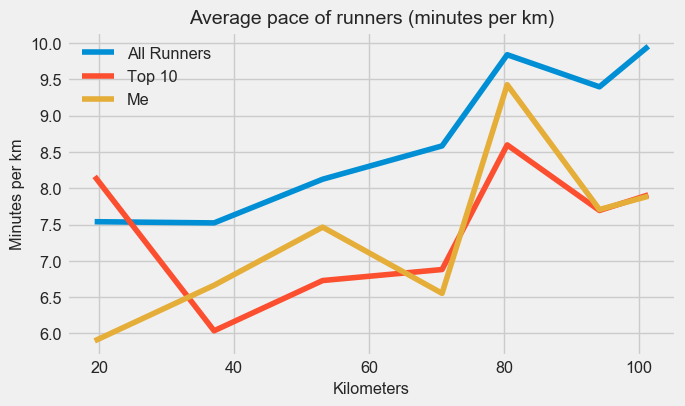

In [59]:

plots.plot(y = ["All Runners","Top 10","Me"], x = ["cp_km_all"], figsize=(7,4))
plt.title('Average pace of runners (minutes per km)')
plt.ylabel('Minutes per km', fontsize="small")
plt.xlabel('Kilometers')